<a href="https://colab.research.google.com/github/eddieHerman-lab/Analise-de-sentimento/blob/main/SVM_project_Tumores_mamarios_predicao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Analise de Classificacao de Tumores mamários ultilizando SVM (Uma ánalise comparativa) ***

Nesta análise, utilizamos o Support Vector Machine (SVM) para a classificação de tumores malignos e benignos com base no conjunto de dados do Breast Cancer Wisconsin. Consideramos diferentes abordagens, incluindo o SVM linear e o SVM com kernel RBF, para entender a separabilidade dos dados e a melhor forma de modelá-los.

O dataset de câncer de mama do scikit-learn contém características extraídas de imagens digitalizadas de aspirados por agulha fina (FNA) de massas mamárias. Cada instância representa medidas de características de células no tecido mamário. A variável alvo indica se o tecido é maligno (0) ou benigno (1).
As características incluem medidas como raio, textura, perímetro, área, suavidade, compacidade, concavidade, etc. Essas medidas são calculadas para o núcleo celular e podem indicar anomalias associadas ao câncer.
Importância: Entender seu dataset é fundamental. Neste caso, trabalhando com um problema médico real onde o objetivo é classificar corretamente tumores como malignos ou benignos. Falsos negativos (classificar erroneamente um tumor maligno como benigno) podem ter consequências graves.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score


2. Normalização dos dados

In [ ]:
# Carregando o dataset de câncer de mama
data = load_breast_cancer()
X = data.data
y = data.target

# Convertendo para DataFrame para melhor visualização
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

# Visualizando as primeiras linhas do dataset
print(df.head())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

A normalização (ou padronização) é crucial para algoritmos baseados em distância, como SVM. O StandardScaler transforma os dados para que cada característica tenha média 0 e desvio padrão 1.
Por que é importante para SVMs? SVMs são sensíveis à escala dos dados porque:

A otimização do hiperplano de margem máxima é influenciada pelas magnitudes das características
Kernels como RBF calculam distâncias entre pontos, que são distorcidas se as características tiverem escalas diferentes
O parâmetro de regularização C aplica-se igualmente a todas as características

Consideração avançada: Para dados muito enviesados (skewed), você pode considerar o RobustScaler ou transformações logarítmicas para características específicas.

3. Visualização dos Dados

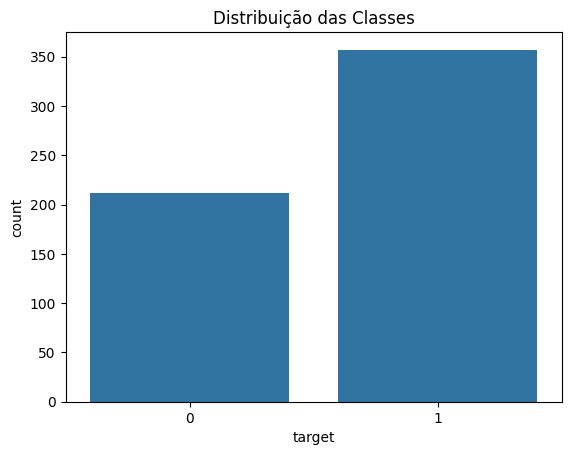

In [ ]:
sns.countplot(x='target', data=df)
plt.title("Distribuição das Classes")
plt.show()

Esta visualização mostra a distribuição das classes (maligno vs. benigno). É importante verificar se o dataset está balanceado, pois desbalanceamento pode afetar o desempenho do modelo.
Implicações para SVMs:

Em dados desbalanceados, SVMs podem ser enviesados para a classe majoritária
Você pode ajustar o parâmetro class_weight='balanced' no SVC para compensar o desbalanceamento
Técnicas como SMOTE para oversampling da classe minoritária também podem ser úteis

4. Divisão dos Dados

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Esta é a divisão dos dados em conjuntos de treino (80%) e teste (20%). O parâmetro random_state garante reprodutibilidade dos resultados.
Conceitos importantes:

Overfitting: quando o modelo "decora" os dados de treino, mas não generaliza bem
Validação cruzada: técnica mais robusta que uma simples divisão treino/teste
Estratificação: garantir que a proporção de classes seja mantida (use stratify=y)

Abordagem avançada: Considere implementar uma validação cruzada aninhada (nested cross-validation) para avaliar o desempenho do modelo enquanto otimiza hiperparâmetros.

5. Análise de Componentes Principais (PCA)

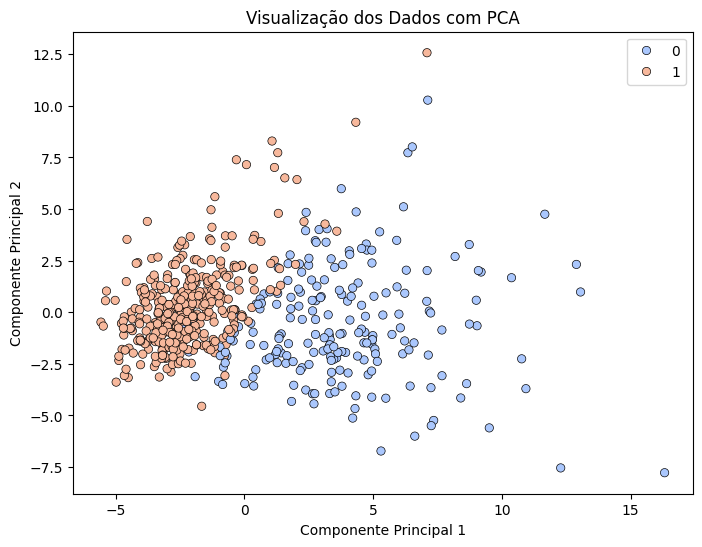

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm', edgecolor='k')
plt.title("Visualização dos Dados com PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

PCA é uma técnica de redução de dimensionalidade que projeta os dados em um espaço de menor dimensão, preservando a máxima variância possível. Aqui, você reduz para 2 dimensões para visualização.
Aspectos importantes do PCA:

Reduz dimensionalidade mantendo a variância máxima
Ajuda a lidar com multicolinearidade (características correlacionadas)
Pode melhorar desempenho reduzindo ruído
Facilita visualização

Como interpretar os componentes: Cada componente principal é uma combinação linear das características originais. Os atributos pca.components_ e pca.explained_variance_ratio_ podem mostrar quais características originais contribuem mais para cada componente.
PCA e SVM: PCA pode ajudar SVMs reduzindo o custo computacional e melhorando o desempenho em dados de alta dimensionalidade, especialmente quando há muito ruído ou multicolinearidade.

6. SVM com Kernel Linear

In [ ]:
svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
svm_linear.fit(X_train, y_train)

y_pred_linear = svm_linear.predict(X_test)

print("=== SVM Linear ===")
print(confusion_matrix(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))


=== SVM Linear ===
[[41  2]
 [ 3 68]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.97      0.96      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



SVM (Support Vector Machine) busca encontrar um hiperplano que separe as classes com a maior margem possível. O kernel linear procura um hiperplano linear para separar as classes.
Parâmetros importantes:

kernel='linear': Usa um kernel linear (hiperplano reto)
C=1.0: Parâmetro de regularização. Controla o trade-off entre maximizar a margem e minimizar os erros de classificação

C menor: margem maior, mais erros permitidos (mais generalização)
C maior: margem menor, menos erros permitidos (possível overfitting)



Matemática por trás do SVM Linear:
A função objetivo que o SVM minimiza é:

1/2 ||w||² + C * Σ ξᵢ

||w||² está relacionado à largura da margem (queremos maximizar a margem)
ξᵢ são as variáveis de folga que permitem classificações erradas
C controla o equilíbrio entre esses objetivos



Quando usar Kernel Linear:

Quando os dados são linearmente separáveis ou quase.
Quando o número de características é grande em relação ao número de amostras.
Quando queremos interpretabilidade (os coeficientes têm significado direto)

7. SVM com Kernel RBF

In [ ]:
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_rbf.fit(X_train, y_train)

y_pred_rbf = svm_rbf.predict(X_test)

print("=== SVM RBF ===")
print(confusion_matrix(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))


=== SVM RBF ===
[[41  2]
 [ 1 70]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



O kernel RBF (Radial Basis Function, também chamado Gaussiano) mapeia os dados para um espaço de dimensão infinita, permitindo encontrar fronteiras de decisão não-lineares.
Parâmetros chave:

kernel='rbf': Usa a função de base radial: K(x,y) = exp(-γ||x-y||²)
C=1.0: Como no linear, controla a regularização
gamma='scale': Define o quão longe a influência de um único exemplo de treinamento alcança

gamma menor: influência mais ampla, fronteira mais suave
gamma maior: influência mais localizada, fronteira mais complexa



A matemática do Kernel RBF:

O kernel RBF mapeia implicitamente os dados para um espaço de dimensão infinita
Função K(x,y) = exp(-γ||x-y||²) representa o produto escalar nesse espaço
Um ponto de dados influencia a decisão com base na distância euclidiana

Quando usar Kernel RBF:

Quando os dados não são linearmente separáveis
Em problemas complexos onde as relações entre variáveis são não-lineares.
Em dados médicos, como nesse caso, onde relações biológicas raramente são lineares.

Aplicação em dados médicos: Dados de diagnóstico médico frequentemente exibem padrões não-lineares complexos. O RBF é particularmente útil porque:

Pode capturar interações complexas entre características
É eficaz mesmo quando a estrutura exata da não-linearidade é desconhecida
Geralmente supera kernels lineares em dados biológicos

8. Avaliação do Modelo

In [ ]:
print(confusion_matrix(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))

[[41  2]
 [ 3 68]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.97      0.96      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



Estas são métricas para avaliar o desempenho do modelo.
Matriz de Confusão:

Verdadeiros Positivos (VP): casos corretamente identificados como positivos
Falsos Positivos (FP): casos negativos incorretamente identificados como positivos
Verdadeiros Negativos (VN): casos corretamente identificados como negativos
Falsos Negativos (FN): casos positivos incorretamente identificados como negativos

Relatório de Classificação:

Precisão = VP / (VP + FP): proporção de identificações positivas corretas
Recall (Sensibilidade) = VP / (VP + FN): proporção de positivos reais identificados
F1-Score: média harmônica de precisão e recall
Support: número de ocorrências de cada classe

Importância no contexto médico:

Falsos Negativos (não detectar câncer quando existe) são geralmente mais graves que Falsos Positivos
Em diagnósticos médicos, a sensibilidade (recall) é frequentemente mais importante que a precisão
Considere usar métricas ponderadas ou específicas para o domínio médico

ANÁLISE EXPLORATÓRIA VISUAL GENERALISTA

Matriz de Correlação

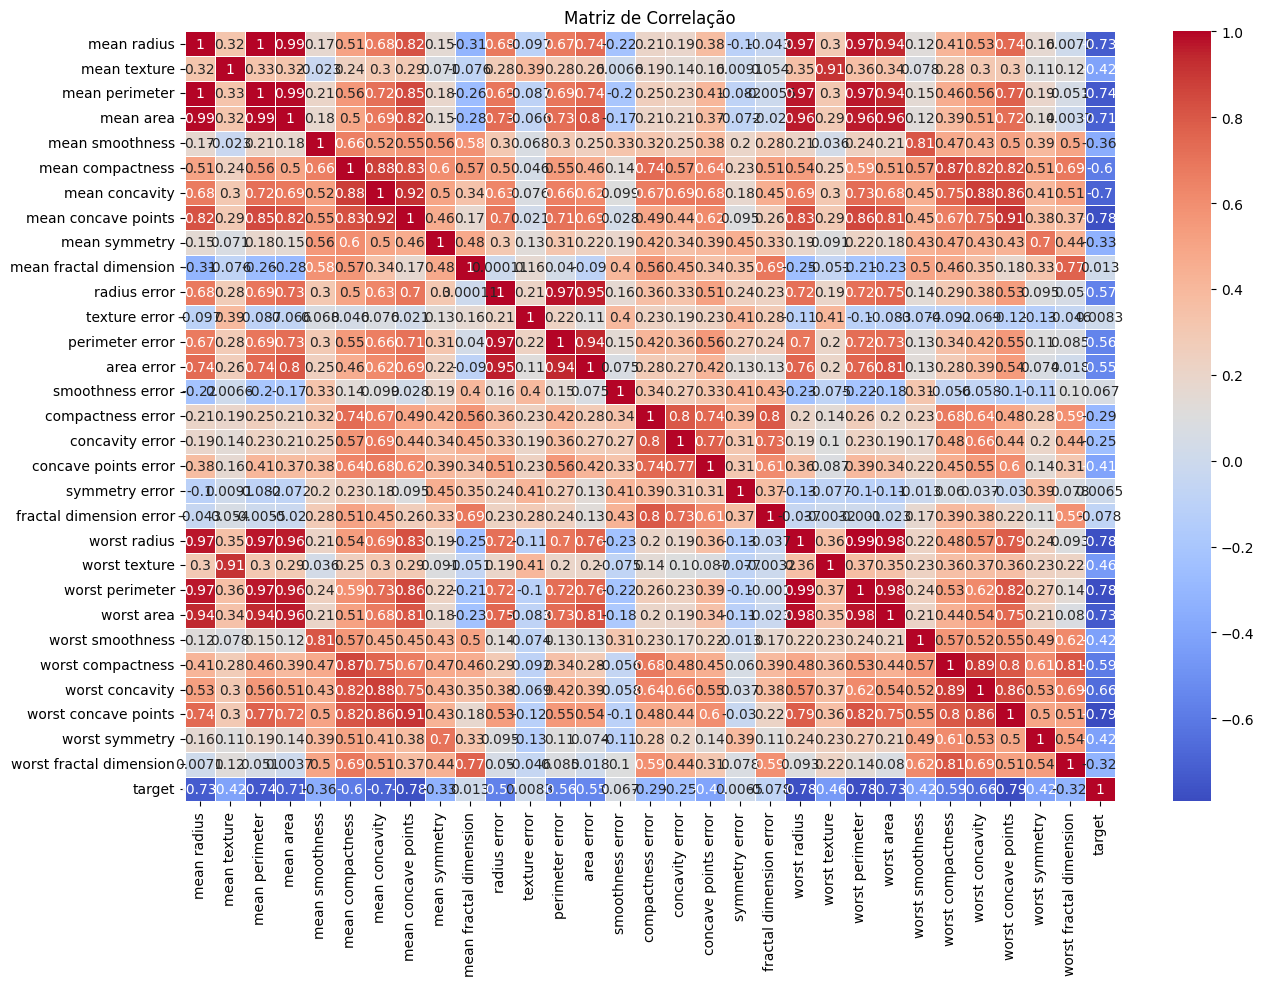

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()

O Heatmap de correlacao  mostra uma relação linear entre as variáveis de um conjunto de dados. Ele coloca as variáveis(caracteristicas) em um eixo X e um eixo Y, indicando (dentro de um quadrado) a correlação entre elas. O valor da correlação varia de -1 até 1.
1 Valor positivo: indica que as variáveis seguem para a mesma direção;
2 Valor negativo: indica que as variáveis estão em direções opostas.

Na cor do mapa de calor auxilia na visualização dos dados. Aqui foi ultilizado o exemplo da grade  de cores “coolwarm”, que mostra quanto mais negativa a correlação, mais azul fica, e quando mais positiva a correlação mais vermelho fica.

Visualização da distribuicao das caracteristicas por classe

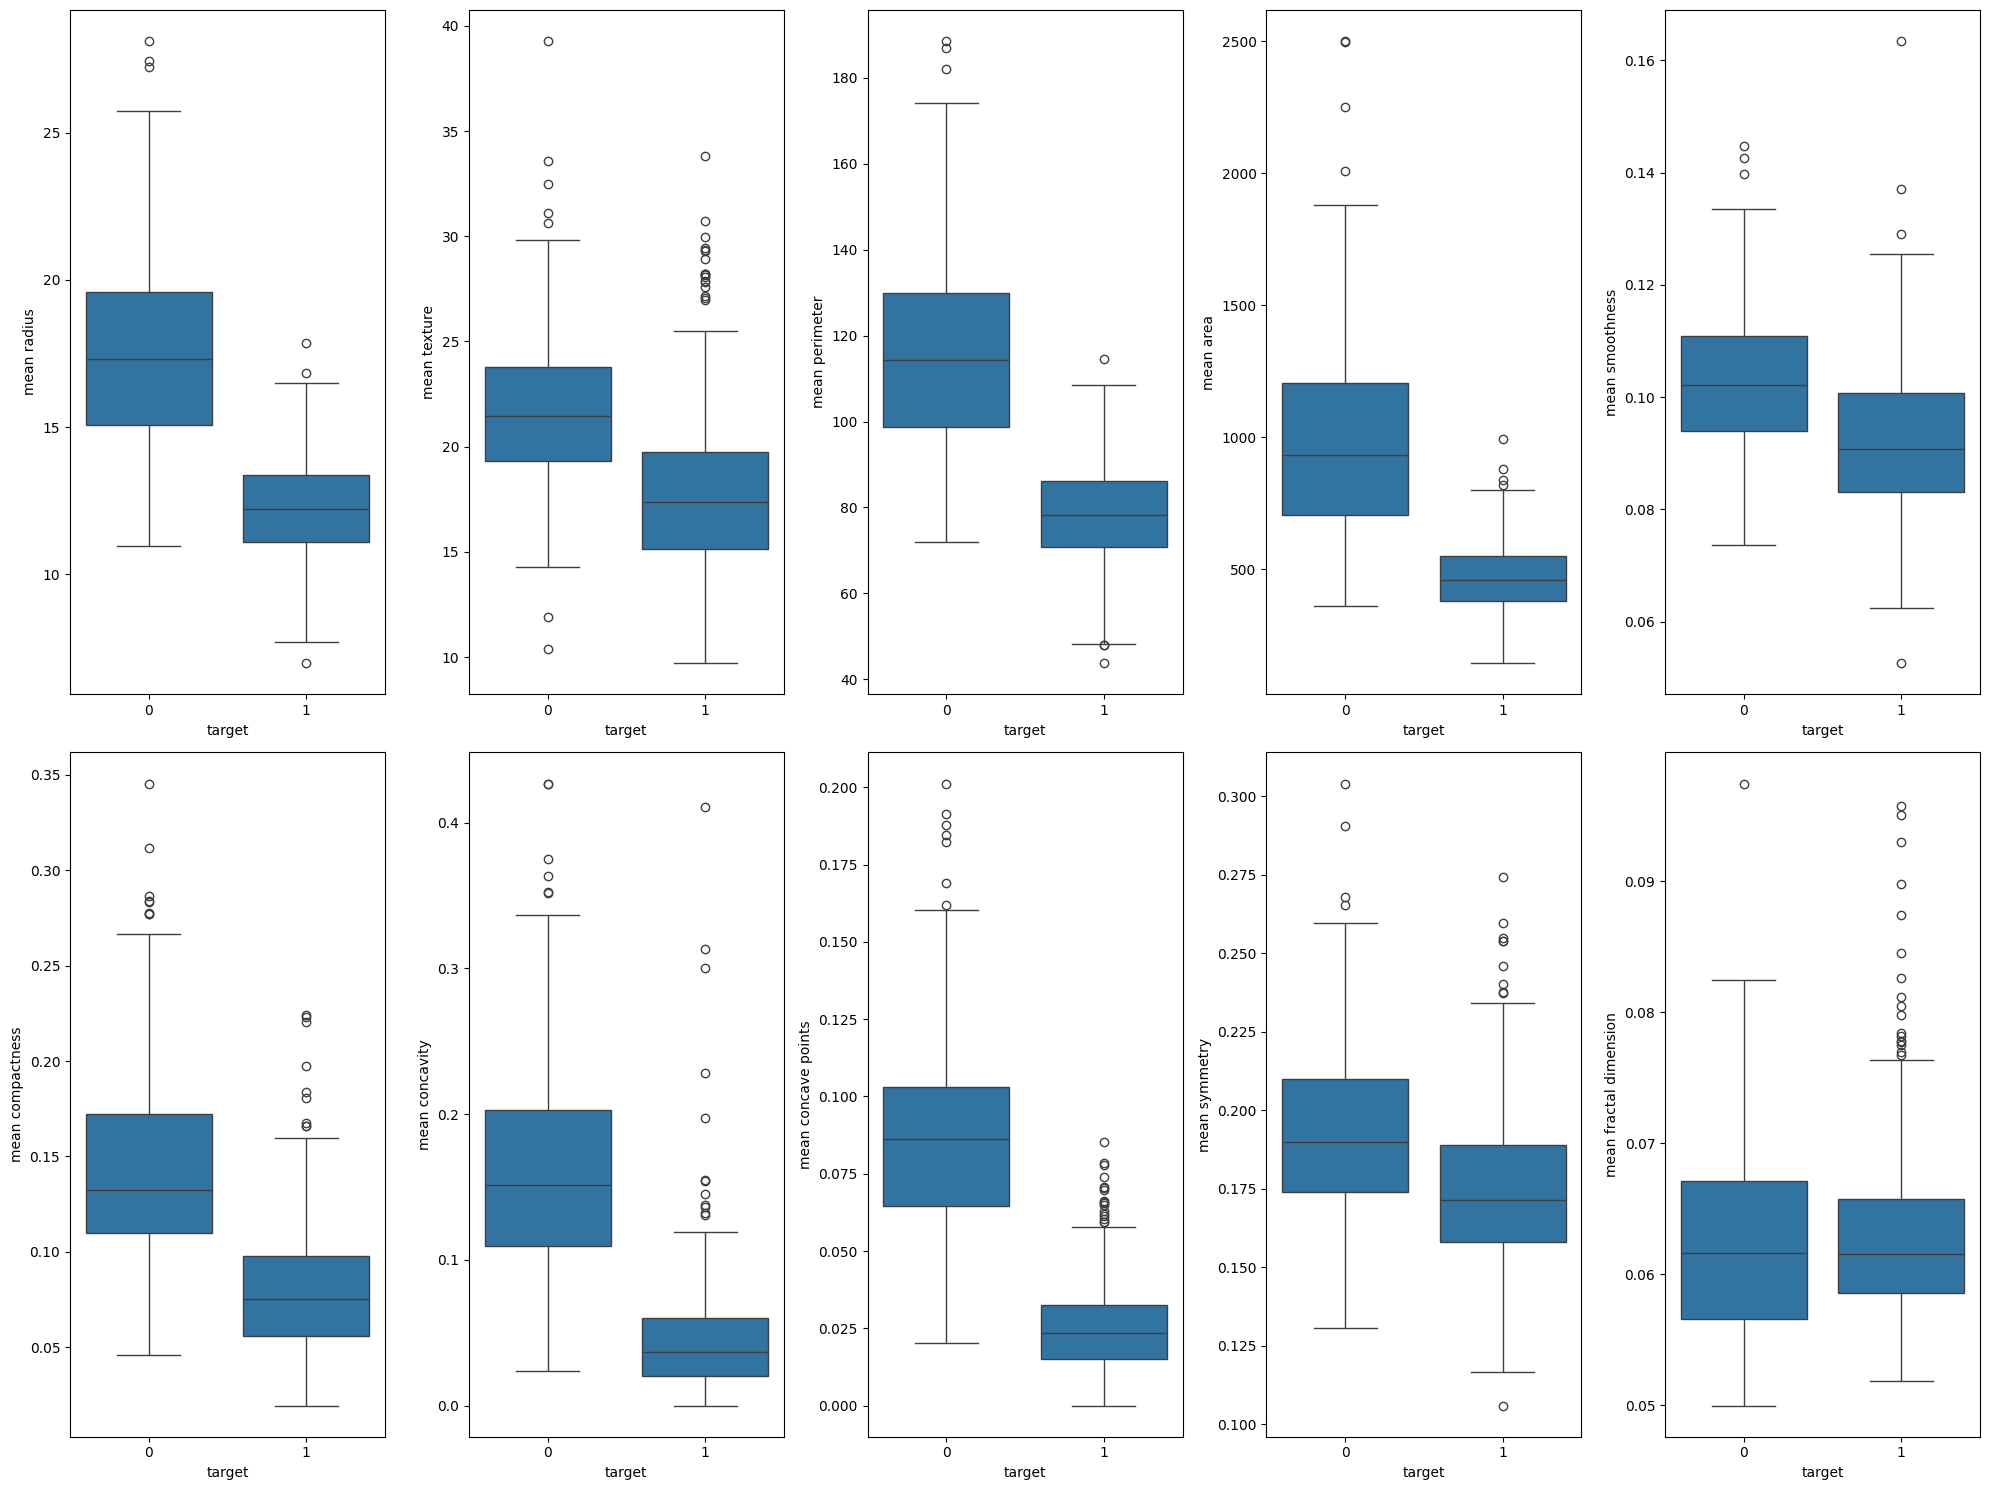

In [ ]:
features = df.columns[:-1]
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features[:10]):  # Primeiras 10 características
    plt.subplot(2, 5, i + 1)
    sns.boxplot(x='target', y=feature, data=df)
plt.tight_layout()
plt.show()

O boxplot (ou diagrama de caixas) é uma ferramenta poderosa para visualizar a distribuição de dados e identificar outliers, dispersão e assimetria

INTERPRETACAO:

Componentes do Boxplot:
Linha central (mediana): Divide os dados ao meio.

Se deslocada para cima ou para baixo, sugere assimetria na distribuição.
Caixa (Quartis Q1 e Q3): Representa o intervalo interquartil (IQR = Q3 - Q1), onde estão 50% dos dados centrais.

Se uma classe tem a caixa deslocada para cima, seus valores médios tendem a ser maiores.
Extremos dos "bigodes": Aproximadamente 1.5 vezes o IQR.

Indicam a faixa de variação típica dos dados.
Pontos fora dos bigodes (outliers): Valores extremos que podem indicar anomalias ou padrões interessantes.

Nesse caso, pode indicar características distintivas entre tumores benignos e malignos.

Observações sobre os gráficos:
Variáveis como mean radius, mean perimeter e mean area têm valores significativamente maiores em tumores malignos (classe 0). Isso indica que tumores malignos tendem a ser maiores.
Variáveis como mean concavity e mean concave points mostram uma diferença clara entre classes, sugerindo que a concavidade das células pode ser um fator importante para a classificação.
Algumas variáveis, como mean smoothness e mean fractal dimension, parecem ter distribuições semelhantes entre as classes, o que pode indicar menor relevância para a classificação.

Observações:

Se uma variável tem uma grande diferença entre as classes (caixas bem separadas), ela pode ser um bom preditor para um modelo de Machine Learning.
Se as caixas são muito sobrepostas, a variável pode não ser tão útil para a separação das classes.
Outliers podem indicar casos raros que podem influenciar o modelo e precisam ser analisados.

9. Otimização de Hiperparâmetros

In [ ]:
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf']
}

param_grid_linear = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear']
}
# Criando o StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rbf = GridSearchCV(SVC(random_state=42), param_grid_rbf, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
grid_rbf.fit(X_train, y_train)

print("Melhores parâmetros para SVM RBF:", grid_rbf.best_params_)
print("Melhor score para SVM RBF:", grid_rbf.best_score_)

# GridSearchCV para SVM Linear
grid_linear = GridSearchCV(SVC(random_state=42), param_grid_linear, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
grid_linear.fit(X_train, y_train)

print("Melhores parâmetros para SVM Linear:", grid_linear.best_params_)
print("Melhor score para SVM Linear:", grid_linear.best_score_)

# Avaliando o melhor modelo
best_model = grid_rbf.best_estimator_
y_pred = best_model.predict(X_test)

print("=== Melhor Modelo SVM ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores parâmetros para SVM RBF: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Melhor score para SVM RBF: 0.9780219780219781
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Melhores parâmetros para SVM Linear: {'C': 0.1, 'kernel': 'linear'}
Melhor score para SVM Linear: 0.9736263736263737
=== Melhor Modelo SVM ===
[[41  2]
 [ 0 71]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



GridSearchCV testa todas as combinações possíveis de hiperparâmetros especificados e seleciona a melhor combinação com base na métrica de avaliação.
Hiperparâmetros do SVM e seus efeitos:

C (regularização):

Controla o trade-off entre erro de classificação e simplicidade da fronteira
C baixo: fronteira mais simples, possivelmente subajustada (underfitting)
C alto: fronteira mais complexa, possivelmente superajustada (overfitting)


gamma (para kernel RBF):

Controla a "proximidade" necessária para pontos influenciarem a fronteira
gamma baixo: influência ampla, fronteira mais suave
gamma alto: influência localizada, fronteira mais detalhada e possivelmente superajustada


kernel:

linear: fronteira linear, boa para dados de alta dimensionalidade
rbf: fronteira não-linear, bom para relações complexas
poly: fronteira polinomial, útil para algumas relações não-lineares
sigmoid: semelhante a uma rede neural de uma camada



Estratégias avançadas:

RandomizedSearchCV é mais eficiente para espaços de parâmetros grandes
Bayesian Optimization pode ser mais eficiente que grid search
Considere diferentes métricas de scoring ('f1', 'recall', 'precision') dependendo do caso

10. Visualização da Fronteira de Decisão

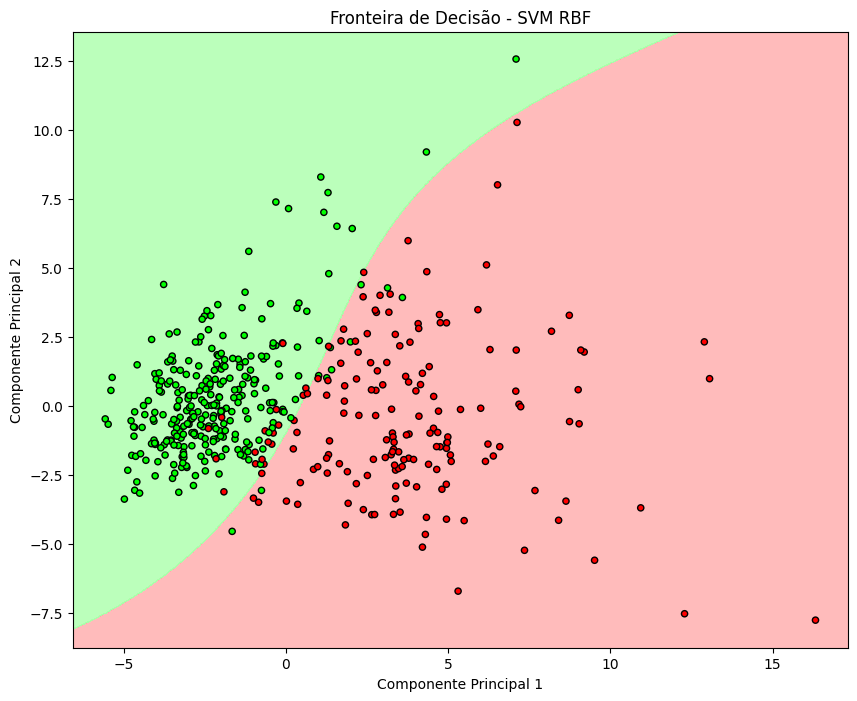

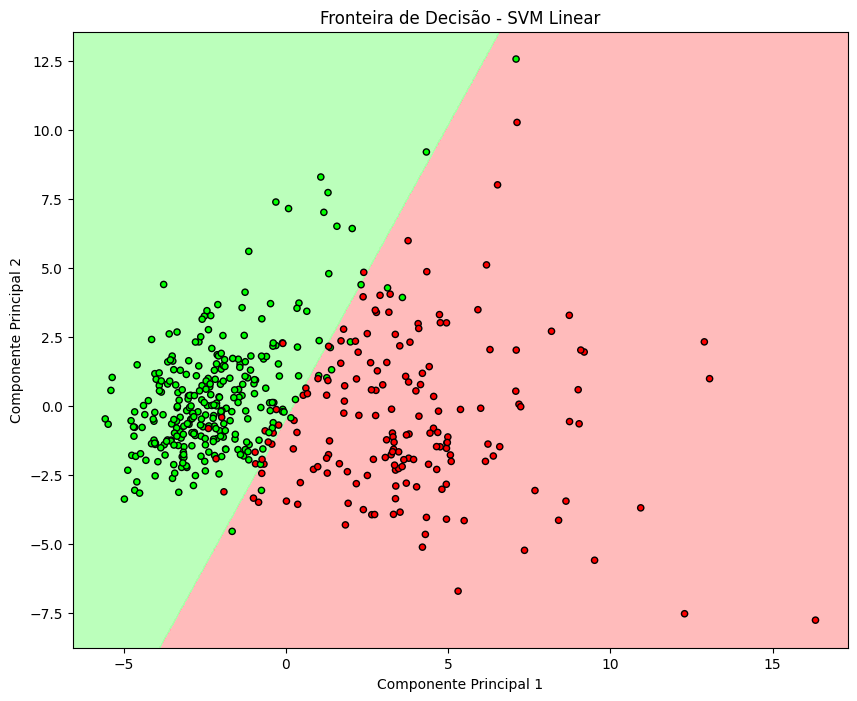

In [ ]:
def plot_decision_boundary(X, y, model, title):
     h = .02  # step size in the mesh

     # Create color maps
     cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
     cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

     # Plot the decision boundary
     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

     Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
     Z = Z.reshape(xx.shape)

     plt.figure(figsize=(10, 8))
     plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
     plt.title(title)
     plt.xlabel("Componente Principal 1")
     plt.ylabel("Componente Principal 2")
     plt.show()

    # Aplicar PCA nos dados de treino
X_train_pca = pca.transform(X_train)

# Treinar modelos com dados PCA
svm_rbf_pca = SVC(kernel='rbf', C=grid_rbf.best_params_['C'],
                  gamma=grid_rbf.best_params_['gamma'], random_state=42)
svm_rbf_pca.fit(X_train_pca, y_train)

svm_linear_pca = SVC(kernel='linear', C=grid_linear.best_params_['C'], random_state=42)
svm_linear_pca.fit(X_train_pca, y_train)

# Visualizar fronteiras de decisão
plot_decision_boundary(X_train_pca, y_train, svm_rbf_pca, "Fronteira de Decisão - SVM RBF")
plot_decision_boundary(X_train_pca, y_train, svm_linear_pca, "Fronteira de Decisão - SVM Linear")



Esta função visualiza como o modelo está separando as classes no espaço bidimensional do PCA.
O que observar:

Complexidade da fronteira: fronteiras muito complexas podem indicar overfitting
Pontos mal classificados: analisar os erros pode revelar padrões
Diferenças entre kernels: comparar fronteiras de diferentes kernels

Aplicação ao diagnóstico de câncer:

Uma fronteira muito irregular pode indicar que o modelo está "decorando" os dados
Uma fronteira muito simplificada pode não capturar relações importantes
O ideal é uma fronteira que separe bem as classes sem ser excessivamente complexa

11. Análise ROC e AUC

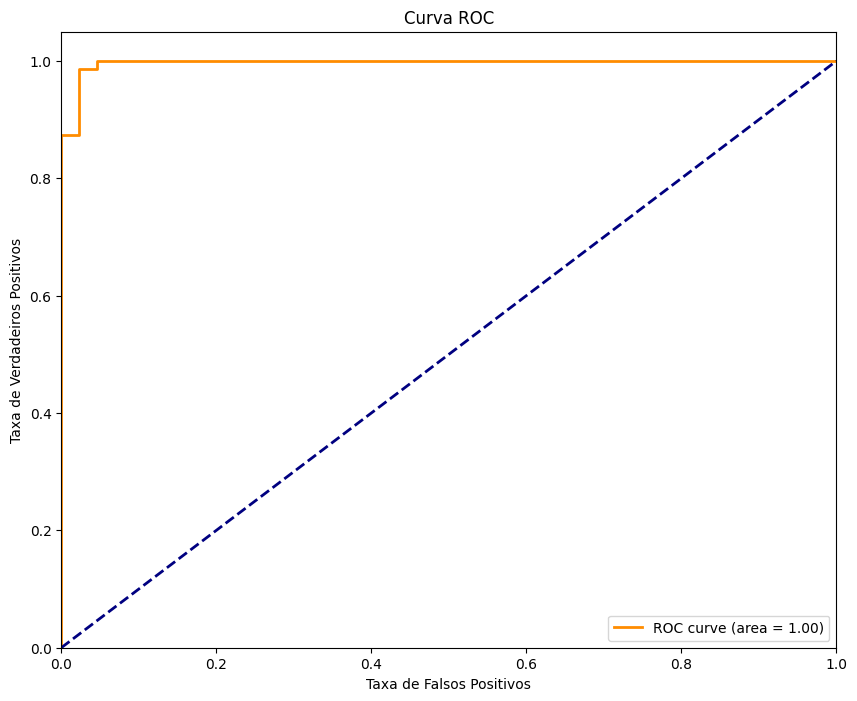

In [ ]:
y_pred_proba = best_model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


ROC (Receiver Operating Characteristic): mostra o desempenho de um modelo de classificação em diferentes limiares
AUC (Area Under Curve): mede a área sob a curva ROC, variando de 0.5 (aleatório) a 1.0 (perfeito)

Conceitos importantes:

TPR (True Positive Rate) = Sensibilidade = Recall
FPR (False Positive Rate) = 1 - Especificidade
Um bom classificador maximiza TPR enquanto minimiza FPR

Aplicação médica:

Em diagnósticos, diferentes limiares de decisão têm diferentes consequências clínicas
A curva ROC permite escolher um limiar apropriado conforme a necessidade clínica
AUC alta indica que o modelo diferencia bem entre tumores benignos e malignos

12. Comparação com Outros Algoritmos

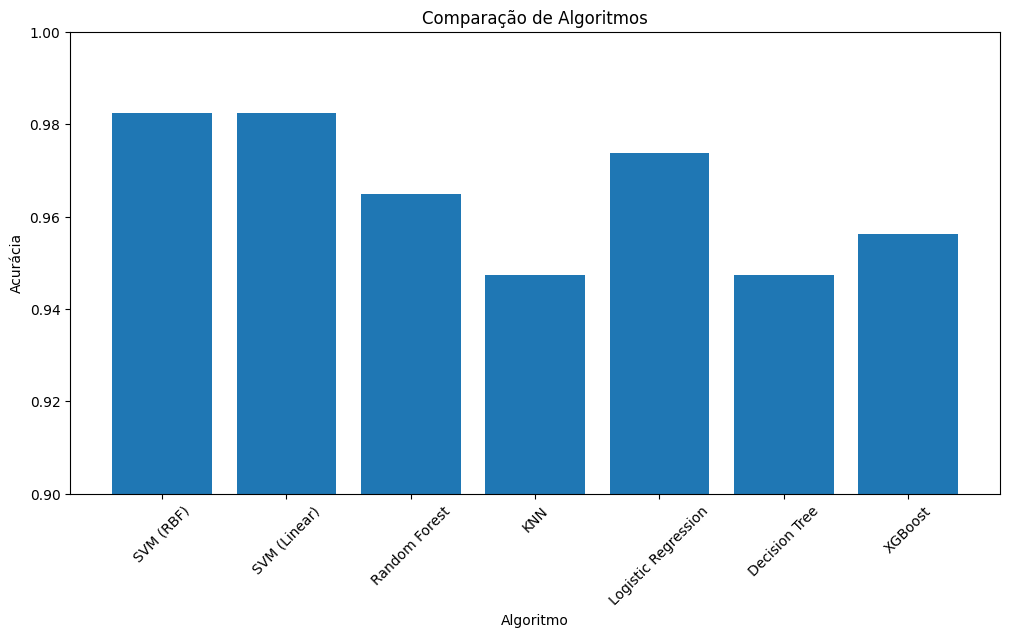

In [ ]:
models = {
    'SVM (RBF)': best_model,
    'SVM (Linear)': grid_linear.best_estimator_,
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}
# Resultados para cada modelo
results = {}

for name, model in models.items():
    if name not in ['SVM (RBF)', 'SVM (Linear)']:  # Estes já foram treinados
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = (y_pred == y_test).mean()
    results[name] = accuracy

# Plotando a comparação
plt.figure(figsize=(12, 6))
plt.bar(results.keys(), results.values())
plt.xlabel('Algoritmo')
plt.ylabel('Acurácia')
plt.title('Comparação de Algoritmos')
plt.xticks(rotation=45)
plt.ylim(0.90, 1.0)  # Ajuste conforme necessário
plt.show()

Esta parte compara o desempenho do SVM com outros algoritmos populares de classificação.
Algoritmos e suas características:

SVM: bom para dados de média dimensionalidade, eficaz com fronteiras não-lineares
Random Forest: robusto, lida bem com não-linearidade, menos propenso a overfitting
Logistic Regression: simples, interpretável, bom para dados lineares
KNN: simples, não-paramétrico, sensível à escala e dimensionalidade
XGBoost: poderoso, geralmente tem alto desempenho, pode ser difícil de calibrar

O que procurar na comparação:

Diferenças significativas de desempenho entre algoritmos
Trade-offs entre precisão e recall
Tempo de treinamento e inferência
Complexidade e interpretabilidade

Consideração para diagnóstico médico:

Modelos mais complexos nem sempre são melhores
A interpretabilidade pode ser crucial para adoção clínica
Considere ensemble methods que combinam múltiplos modelos

Conceitos Avançados para Análise de Dados Médicos com SVMs
1. SVM One-Class para Detecção de Anomalias

In [ ]:
from sklearn.svm import OneClassSVM

# Treinando apenas em exemplos benignos
X_benign = X_train[y_train == 1]
one_class_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma='scale')
one_class_svm.fit(X_benign)

OneClassSVM(nu=0.1)

O One-Class SVM aprende a fronteira que envolve os dados normais (benignos) e pode detectar exemplos anômalos (possivelmente malignos).
Aplicações:

Detecção de outliers nos dados
Monitoramento para detectar padrões incomuns que podem indicar câncer
Útil quando você tem muitos exemplos de uma classe mas poucos da outra

2. Importância de Características no SVM Linear

In [ ]:
coef = svm_linear.coef_[0]
feature_importance = pd.DataFrame({'Feature': data.feature_names, 'Importance': np.abs(coef)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

No SVM linear, os coeficientes indicam a importância relativa de cada característica para a separação.
Como interpretar:

Características com coeficientes maiores (em magnitude) têm mais influência na decisão
O sinal do coeficiente indica a direção do efeito
Pode ajudar médicos a entender quais características são mais importantes para o diagnóstico

3. Efeito do Desequilíbrio de Classes

In [ ]:

# Calculando pesos das classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# SVM com pesos de classe
weighted_svm = SVC(kernel='rbf', C=1.0, class_weight=class_weight_dict)
weighted_svm.fit(X_train, y_train)
print(weighted_svm)


SVC(class_weight={0: 1.3461538461538463, 1: 0.7954545454545454})


Em datasets médicos, as classes podem ser desequilibradas (ex: mais casos benignos que malignos). O parâmetro class_weight ajusta a importância de cada classe.
Por que é importante:

Previne viés para a classe majoritária.
Particularmente crucial quando falsos negativos têm consequências graves.
Pode melhorar significativamente o recall para a classe minoritária

4. Calibração de Probabilidades

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


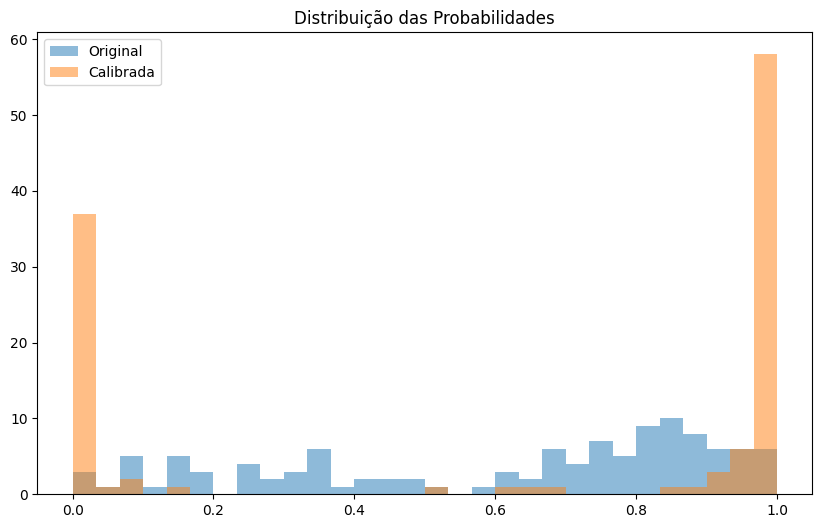

In [ ]:

# Calibrar o SVM para obter probabilidades mais confiáveis
calibrated_svm = CalibratedClassifierCV(estimator=best_model, cv='prefit')
calibrated_svm.fit(X_train, y_train)
#Probabilidades originais
y_scores = best_model.decision_function(X_test)
proba_original = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())


# Probabilidades calibradas
proba_calibrada = calibrated_svm.predict_proba(X_test)
# Comparar as distribuições
plt.figure(figsize=(10, 6))
plt.hist(proba_original, bins=30, alpha=0.5, label='Original')
plt.hist(proba_calibrada[:, 1], bins=30, alpha=0.5, label='Calibrada')
plt.legend()
plt.title('Distribuição das Probabilidades')
plt.show()

SVMs não produzem naturalmente probabilidades bem calibradas. O CalibratedClassifierCV ajusta as saídas para refletir melhor as probabilidades verdadeiras.
Importância clínica:

Em diagnósticos médicos, não apenas a classificação, mas a confiança na classificação é importante que
médicos podem usar probabilidades calibradas para tomar decisões mais informadas.
Permite melhor comunicação de incerteza em diagnósticos

5. Validação Cruzada Estratificada

In [ ]:

# Validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_scaled, y, cv=cv, scoring='recall')
print(f' Validacao Cruzada estratificada= {scores}')

 Validacao Cruzada estratificada= [1.         0.97183099 1.         0.98611111 1.        ]


A validação cruzada estratificada mantém a proporção de classes em cada fold, garantindo avaliação robusta.
Benefícios:

Avaliação mais confiável quando as classes são desequilibradas.
Reduz a variância na estimativa de desempenho.
Essencial para datasets médicos pequenos

Conclusão!

O diagnóstico de câncer de mama usando SVMs envolve uma combinação de compreensão do problema médico, preparação cuidadosa dos dados, seleção e otimização de modelos, e avaliação apropriada.
A principal força do SVM com kernel RBF para este problema é sua capacidade de capturar relações não-lineares complexas que são comuns em dados biológicos. A otimização de hiperparâmetros, especialmente C e gamma, é crucial para encontrar o equilíbrio entre generalização e ajuste aos dados.
Ibservacoes: Dev-se considerar pra mais visulaizacoes tecnicas de AI Explainable incorporarando técnicas de interpretabilidade do modelo (SHAP, LIME), experimentando também com diferentes técnicas de redução de dimensionalidade além do PCA padrão, e desenvolver uma pipeline completa que possa ser aplicada a novos dados de pacientes.